In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Notebook inspired by https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

In [3]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [4]:
df

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695
5,2020-02-29 18:00:00,ITA,401,105,506,543,1049,228,50,29,1128,18661
6,2020-03-01 18:00:00,ITA,639,140,779,798,1577,528,83,34,1694,21127
7,2020-03-02 18:00:00,ITA,742,166,908,927,1835,258,149,52,2036,23345
8,2020-03-03 18:00:00,ITA,1034,229,1263,1000,2263,428,160,79,2502,25856
9,2020-03-04 18:00:00,ITA,1346,295,1641,1065,2706,443,276,107,3089,29837


In [35]:
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
first_day = datetime.strptime("2020-01-01 00:00:00", FMT)
# use as start day midnight to avoid error depending on the time of arrivale of each row
midnight = datetime.min.time()
first_day = datetime.combine(first_day, midnight)

df['days'] = date.map(lambda x : (datetime.combine(datetime.strptime(x, FMT), midnight) - first_day).days  )
df['data_simple'] = date.map(lambda x : datetime.strptime(x, FMT).strftime("%d-%m"))
df

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,days,data_simple
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324,54,24-02
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623,55,25-02
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587,56,26-02
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014,57,27-02
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695,58,28-02
5,2020-02-29 18:00:00,ITA,401,105,506,543,1049,228,50,29,1128,18661,59,29-02
6,2020-03-01 18:00:00,ITA,639,140,779,798,1577,528,83,34,1694,21127,60,01-03
7,2020-03-02 18:00:00,ITA,742,166,908,927,1835,258,149,52,2036,23345,61,02-03
8,2020-03-03 18:00:00,ITA,1034,229,1263,1000,2263,428,160,79,2502,25856,62,03-03
9,2020-03-04 18:00:00,ITA,1346,295,1641,1065,2706,443,276,107,3089,29837,63,04-03


In [36]:
x = list(df['days'])
y = list(df['totale_casi'])

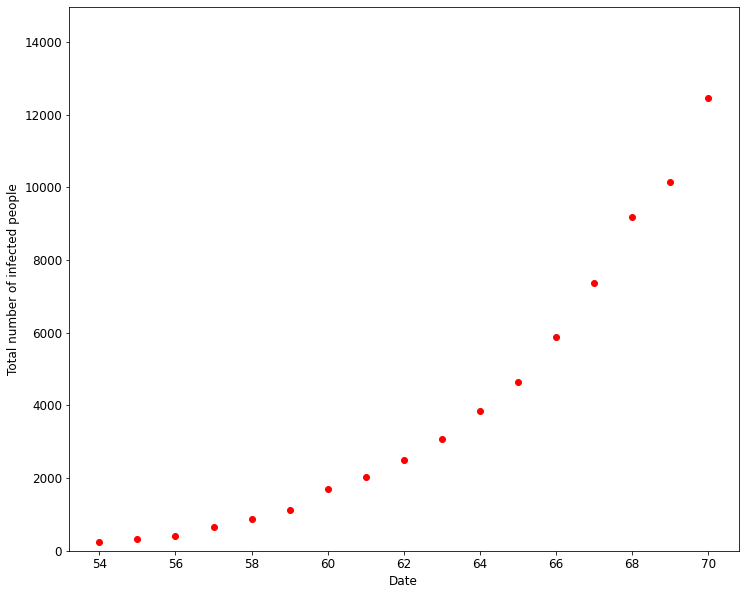

In [37]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.rc('font', size=12)
plt.scatter(x,y,label="Real data",color="red")
plt.xlabel("Date")
plt.ylabel("Total number of infected people")
plt.ylim(0,max(y)*1.2)
plt.show()

In [38]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [39]:
fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])
[a,b,c] = fit[0]

In [40]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
[e_a,e_b,e_c] = errors

In [41]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
pred_x = list(range(max(x),sol))

In [42]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [43]:
#exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])

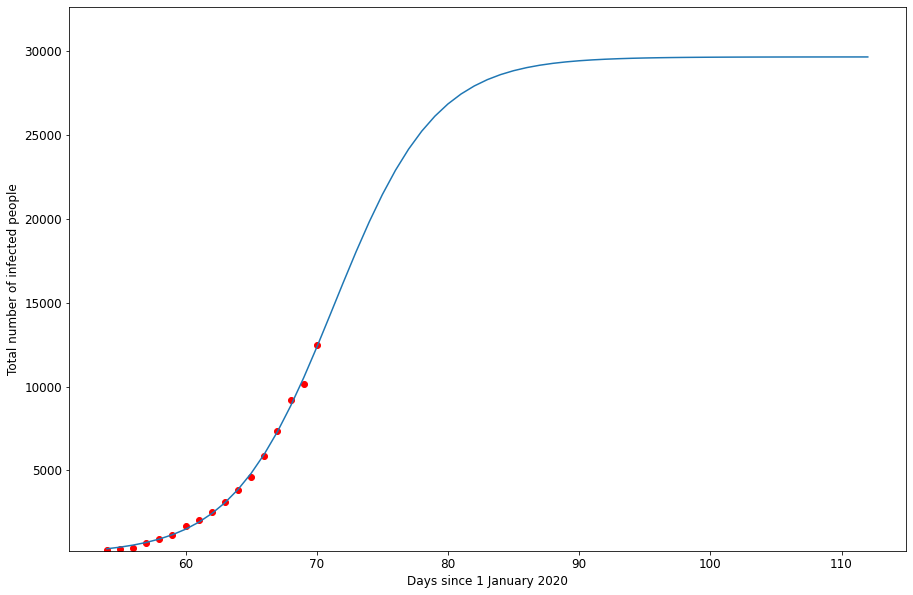

In [44]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', size=12)
plt.scatter(x,y,label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) 
                    for i in x+pred_x], label="Logistic model" )

plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1))
plt.show()

In [33]:
"Expected number of infected people " + str(int(c))

'Expected number of infected people 20000'

In [24]:
peak = datetime.strptime("2020-01-01 00:00:00", FMT) +  timedelta(days=round(b))
"Contagion Peak is expected on: " + peak.strftime("%d %b %Y") + " +/- " + str(int(e_b)) +" days"

OverflowError: cannot convert float infinity to integer

In [25]:
top = datetime.strptime("2020-01-01 00:00:00", FMT) +  timedelta(days=round(sol))
"Expected infection ends on " + top.strftime("%d %b %Y")

'Expected infection ends on 14 Aug 2020'